In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seaborn import heatmap

In [2]:
features = pd.read_hdf('./features/features_data.h5','abc')
features_col_name = features.columns.to_list()

In [3]:
features_weight = pd.read_pickle('./features/features_weights')

In [4]:
features_weight

array([0.16706801, 0.14386047, 0.52130579, 0.49758379, 0.19244736,
       0.14546523, 0.19465327, 0.2386351 , 0.23586511, 0.47238125])

In [5]:
features_col_name

['CPI_y2y_ratio',
 'pmi_y2y_ratio',
 'Inventory_y2y_ratio',
 'Inventory_mom_3_12',
 'usd_mom_20_125',
 'dollar_vol_monthly',
 'carry',
 'carry_mom_20_125',
 'VIX',
 'mom_20_250']

In [6]:
features

,CPI_y2y_ratio,pmi_y2y_ratio,Inventory_y2y_ratio,Inventory_mom_3_12,usd_mom_20_125,dollar_vol_monthly,carry,carry_mom_20_125,VIX,mom_20_250
date,,,,,,,,,,
2006-06-01,0.041817,-0.007634,0.001592,7578.250000,-4.155340,4.823400,-2.03,-0.09520,14.52,6.149323
2006-06-02,0.041817,-0.007634,0.007231,12630.916667,-4.182680,4.711216,-1.78,-0.02232,14.32,6.215534
2006-06-05,0.041817,-0.007634,0.007231,12630.916667,-4.169200,4.711611,-1.94,0.04870,16.65,6.274121
2006-06-06,0.041817,-0.007634,0.007231,12630.916667,-4.140200,4.694080,-1.89,0.11438,17.34,6.348991
2006-06-07,0.041817,-0.007634,0.007231,12630.916667,-4.080600,4.857093,-2.19,0.16910,17.80,6.310230
...,...,...,...,...,...,...,...,...,...,...
2022-03-07,0.079120,-0.037767,-0.046873,-31321.750000,1.306001,4.730727,4.48,0.77904,36.45,20.635354
2022-03-08,0.079120,-0.037767,-0.046873,-31321.750000,1.437721,4.730727,4.48,0.77904,35.13,20.635354
2022-03-09,0.079120,-0.037767,-0.046873,-31321.750000,1.510301,4.730727,4.48,0.77904,32.45,20.635354


In [7]:
wti_data = pd.read_excel('./data/PET_PRI_FUT_S1_D.xls',sheet_name=1,skiprows=2)
wti_data.columns = ['date','F1','F2','F3','F4']
wti_data['date'] = pd.to_datetime(wti_data['date'])
wti_data.dropna(how='any',inplace=True)
wti_data.set_index('date',inplace=True)

In [8]:
features_price = wti_data.reset_index().merge(features.reset_index())

In [9]:
features_price['next_day_ret'] = features_price['F1'].diff(1).shift(-1)

In [10]:
features_price.dropna(how='any',inplace=True)

In [11]:
def labelit(x):
    if x>0:
        return 1
    else:
        return -1

In [12]:
features_price['target'] = features_price['next_day_ret'].apply(lambda x: labelit(x))

In [13]:
X = features_price[features_col_name+['date']].set_index('date')
Y = features_price[['target','date']].set_index('date')

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
X_train, X_test, y_train,y_test = train_test_split(X,Y,test_size=0.3,shuffle=False)
clf2 = GradientBoostingClassifier()
scaler = StandardScaler()

In [15]:
X_train = scaler.fit_transform(X_train.values)
X_test  = scaler.transform(X_test.values)
y_train = y_train.values.squeeze()
y_test = y_test.values.squeeze()

In [16]:
X_train = X_train.dot(features_weight)
X_train = X_train.reshape(X_train.shape[0],1)
X_test  = X_test.dot(features_weight)
X_test = X_test.reshape(X_test.shape[0],1)

In [17]:
def calculate_acc(y_pred, y_test):
    return sum((y_pred == y_test))/len(y_test)

In [18]:
err = []
err_test = []
est_list = list(range(100,1100, 100))
for n_est in range(100,1100,100):
    clf = RandomForestClassifier(n_estimators = n_est, max_depth=5, random_state=42)
    rfc = clf.fit(X_train, y_train)
    err.append(1-calculate_acc(rfc.predict(X_train), y_train))
    err_test.append(1-calculate_acc(rfc.predict(X_test), y_test))

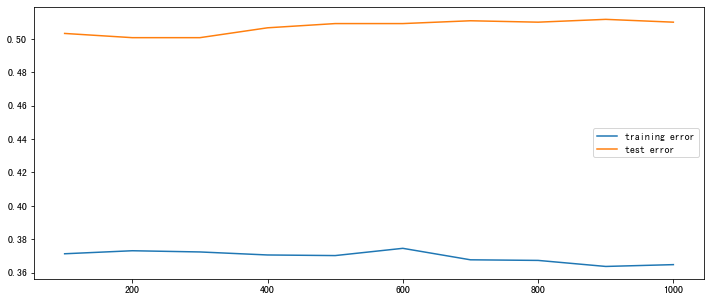

In [19]:
plt.figure(figsize=(12,5))
plt.plot(est_list, err)
plt.plot(est_list, err_test)
plt.legend(['training error','test error'])

In [20]:
err = []
err_test = []
est_list = list(range(100,1100, 100))
for n_est in range(100,1100,100):
    clf = GradientBoostingClassifier(n_estimators = n_est, max_depth=3, random_state=42)
    rfc = clf.fit(X_train, y_train)
    err.append(1-calculate_acc(rfc.predict(X_train), y_train))
    err_test.append(1-calculate_acc(rfc.predict(X_test), y_test))

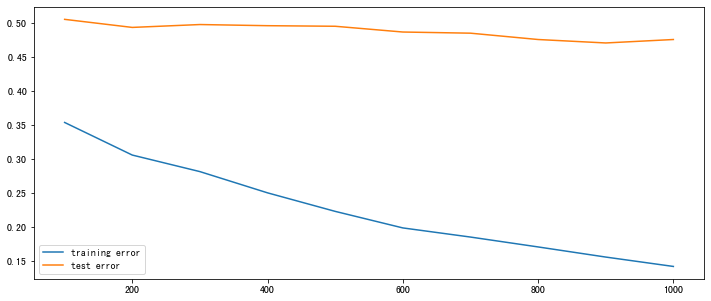

In [21]:
plt.figure(figsize=(12,5))
plt.plot(est_list, err)
plt.plot(est_list, err_test)
plt.legend(['training error','test error'])